In [1]:
# declare universals, import libraries
import wave, struct, math
import numpy as np 
from PIL import Image 

import scipy                     
import matplotlib.pyplot as plt  
import scipy.io.wavfile

import scipy.ndimage
import IPython.display 

In [2]:
# plot spectrogram of a sound file
def plotSpectrogram(file="sound.wav"):
    sample_rate, X = scipy.io.wavfile.read(file)
    plt.specgram(X, Fs=sample_rate, xextent=(0,60))
    print("File: ", file)
    print("Sample rate (Hz): ",sample_rate)

In [47]:
def plotMat(mat):
    mat = np.flip(mat,0)
    X, Y = np.meshgrid(range(mat.shape[0]), range(mat.shape[1]))
    Z = mat[X,Y]

    plt.pcolormesh(Y,X,Z)
    plt.show()

In [54]:
'''
    Loads a picture, converts it to greyscale, then to numpy array, normalise it so that the max value is 1 
    the min is 0, increase the contrast a bit, remove every pixel which intensity is lower that 0.5, 
    then resize the picture using nearest neighbour resampling and outputs the numpy matrix.

'''
def loadPicture(size, file, verbose=1):
    img = Image.open(file)
    img = img.convert("L")
    
    imgArr = np.array(img)
    
    if verbose:
        print("Image original size: ", imgArr.shape)
        
    # increase the contrast of the image
    imgArr = imgArr/np.max(imgArr)
    imgArr = 1/(imgArr+10**15.2)
    
    # scale between 0 and 1
    imgArr -= np.min(imgArr)
    imgArr = imgArr/np.max(imgArr)
    
    # remove low pixel values
    removeLowValues = np.vectorize(lambda x: x if x > 0.5 else 0, otypes=[np.float])
    imgArr = removeLowValues(imgArr)
    
    if size[0] == 0:
        size = imgArr.shape[0], size[1]
    if size[1] == 0:
        size = size[0], imgArr.shape[1]
    resamplingFactor = size[0]/imgArr.shape[0], size[1]/imgArr.shape[1]
    if resamplingFactor[0] == 0:
        resamplingFactor = 1, resamplingFactor[1]
    if resamplingFactor[1] == 0:
        resamplingFactor = resamplingFactor[0], 1
    
    # order : 0=nearestNeighbour, 1:bilinear, 2:cubic etc...
    imgArr = scipy.ndimage.zoom(imgArr, resamplingFactor, order=0)
    
    if verbose:
        print("Resampling factor", resamplingFactor)
        print("Image resized :", imgArr.shape)
        print("Max intensity: ", np.max(imgArr))
        print("Min intensity: ", np.min(imgArr))
        plotMat(imgArr)
    return imgArr

In [37]:
# generate sound from an image file
def genSoundFromImage(file, output="sound.wav", duration=5.0, sampleRate=44100.0, maxfreq = 22000):
    wavef = wave.open(output,'w')
    wavef.setnchannels(1) # mono
    wavef.setsampwidth(2) 
    wavef.setframerate(sampleRate)
    
    max_frame = int(duration * sampleRate)
    max_freq = maxfreq # Hz
    max_intensity = 32767
    
    stepSize = 400 # Hz
    steppingSpectrum = int(max_freq/stepSize)
    
    imgMat = loadPicture((steppingSpectrum, max_frame), file, verbose=0)
    imgMat *= max_intensity
    print("Input: ", file)
    print("Duration (in seconds): ", duration)
    print("Sample rate: ", sampleRate)
    print("Computing each soundframe sum value..")
    for frame in range(max_frame):
        if frame % 60 == 0: # only print once in a while
            IPython.display.clear_output(wait=True)
            print("Progress: ==> {:.2%}".format(frame/max_frame), end="\r")
        signalValue, count = 0, 0
        for step in range(steppingSpectrum):
            intensity = imgMat[step, frame]
            if intensity == 0:
                continue
            # nextFreq is less than currentFreq
            currentFreq = max_freq - step * stepSize
            nextFreq = max_freq - (step+1) * stepSize
            if nextFreq < 0: # if we're at the end of the spectrum
                nextFreq = 0
            for freq in range(nextFreq, currentFreq, 1000): # substep of 1000 Hz works
                signalValue += intensity*math.cos(freq * 2 * math.pi * float(frame) / float(sampleRate))
                count += 1
        if count == 0: count = 1
        signalValue /= count
        
        data = struct.pack('<h', int(signalValue))
        wavef.writeframesraw( data )
        
    wavef.writeframes(''.encode())
    wavef.close()
    IPython.display.clear_output(wait=True)
    print("\nProgress: ==> 100%")
    print("Output: ", output)

In [52]:
infile = "gaysper.jpg"
outfile = "ghost.wav"
genSoundFromImage(file=infile, output=outfile, duration=5.0, sampleRate=44100.0,maxfreq=22000)


Progress: ==> 100%
Output:  ghost.wav


File:  ghost.wav
Sample rate (Hz):  44100


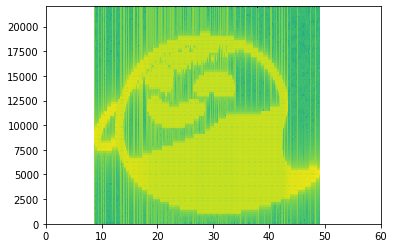

In [53]:
plotSpectrogram(file=outfile)